In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv(r'../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

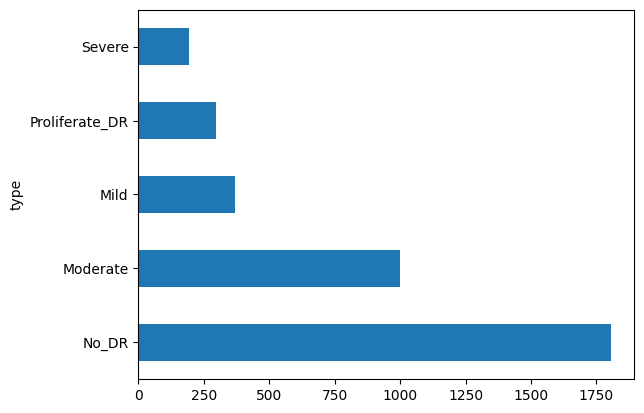

In [3]:
print(df['type'].value_counts())
df['type'].value_counts().plot(kind='barh')

In [4]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("For Training Dataset :")
print(train['type'].value_counts(), '\n')
print("For Testing Dataset :")
print(test['type'].value_counts(), '\n')
print("For Validation Dataset :")
print(val['type'].value_counts(), '\n')

For Training Dataset :
type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

For Testing Dataset :
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

For Validation Dataset :
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [5]:
base_dir = '' 

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [6]:
src_dir = r'../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [7]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [8]:

es=EarlyStopping(monitor="val_acc",min_delta=0.0,patience=100,verbose=1,mode='auto')
mc=ModelCheckpoint(monitor="val_acc",filepath='/kaggle/working//bestmodel.h5',verbose=1,save_best_only=True,mode='auto')


cd = [es,mc]

In [9]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=20,
                    validation_data=val_batches,
                    callbacks=cd)

Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 0.3260 - acc: 0.8962
Epoch 1: val_acc improved from -inf to 0.50727, saving model to /kaggle/working/bestmodel.h5
81/81 [==============================] - 18s 99ms/step - loss: 0.3260 - acc: 0.8962 - val_loss: 0.8982 - val_acc: 0.5073
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - ETA: 0s - loss: 0.2262 - acc: 0.9254
Epoch 2: val_acc improved from 0.50727 to 0.54545, saving model to /kaggle/working/bestmodel.h5
81/81 [==============================] - 8s 99ms/step - loss: 0.2262 - acc: 0.9254 - val_loss: 0.6694 - val_acc: 0.5455
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.1654 - acc: 0.9418
Epoch 3: val_acc improved from 0.54545 to 0.80182, saving model to /kaggle/working/bestmodel.h5
81/81 [==============================] - 7s 92ms/step - loss: 0.1654 - acc: 0.9418 - val_loss: 0.5260 - val_acc: 0.8018
Epoch 4/20
81/81 [==============================] - ETA: 0s - loss: 0.1407 - acc: 0.9512
Epoch 4: val_acc improved from 0.80182 to 0.89091, saving model to /kaggle/working/bestmodel.h5
81/81 [==============================] - 8s 95ms/step - loss: 0.1407 - acc: 0.9512 - val_loss: 0.3309 - val_acc: 0.8909
Epoch 5/20
81/81 [==============================] - ETA: 0s - loss: 0.1081 - acc: 0.9649
Epoch 5

In [10]:
h = history.history
h.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

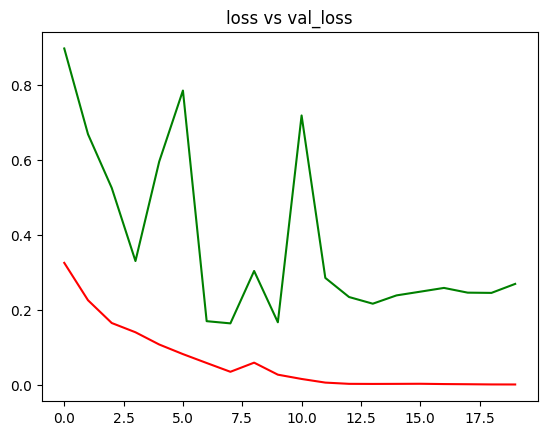

In [11]:
plt.plot(h['loss'], c="red")
plt.plot(h['val_loss'], c="green")

plt.title("loss vs val_loss")

plt.show()

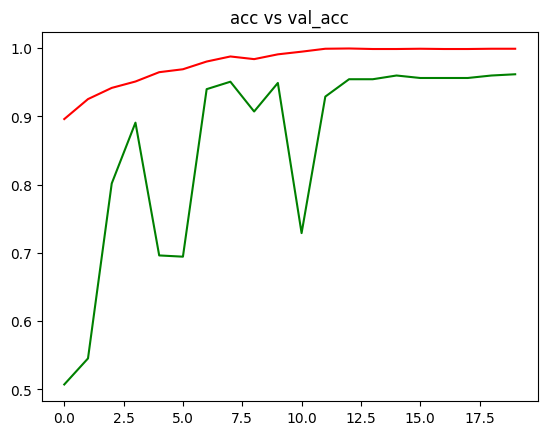

In [12]:
plt.plot(h['acc'], c="red")
plt.plot(h['val_acc'], c="green")

plt.title("acc vs val_acc")

plt.show()

In [17]:
model = load_model("/kaggle/working/bestmodel.h5")
test_accuracy = model.evaluate(test_batches, steps=len(test_batches))
print(f" Test Accuracy: {test_accuracy}")

# Make predictions on the test set
# test_predictions = model.predict(test_batches)
# test_predictions = (test_predictions > 0.5)
# test_predictions

18/18 [==============================] - 2s 75ms/step - loss: 0.3422 - acc: 0.9509
 Test Accuracy: [0.34216517210006714, 0.9509090781211853]


In [14]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
model = load_model('/kaggle/working/bestmodel.h5')

def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
#     new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('Diabetic Retinopathy Not Detected')
    else:
        print('Diabetic Retinopathy Detected')

1/1 [==============================] - 0s 163ms/step
Diabetic Retinopathy Not Detected


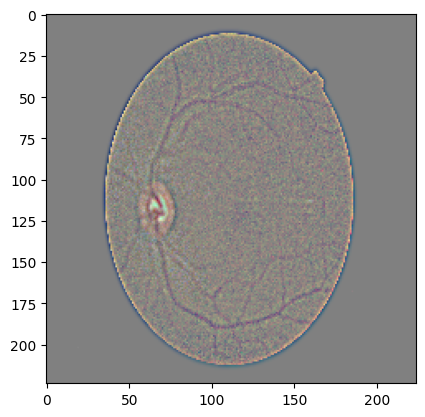

In [15]:
predict_class('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/No_DR/005b95c28852.png')